# Evaluation Notebook

Here each model will be evaluated with the full dataset

In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as sch
import seaborn as sns
import sys
import time
import umap
import json

from torch import cuda
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils import data
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from ipywidgets import widgets, interactive

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Slider
from bokeh.layouts import column
from bokeh.layouts import row
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application
from bokeh.models import ColumnDataSource

sys.path.insert(0, '../scripts')

import vsc
import vae

In [2]:
torch.manual_seed(22)
np.random.seed(22)

device = torch.device("cuda" if cuda.is_available() else "cpu")
print(device)

data_dir = '../../../dataset/'
model_path = '../../../results/models/vae/vaez128.pth'
metadata_dir = '../../../metadata/'
eval_dir='../../../results/models/vae/'
prefix = 'vaez128_'
z = 128

batch_size = 128
alpha = 0.5
beta = 1
c = 160


cuda


In [5]:
def split_data(data_dir, n_split=0.2, batch_size=256):
    
    pin_memory = cuda.is_available()
    workers = 4
    
    # Create training and validation datasets
    image_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        transforms.Normalize((0.0302, 0.0660, 0.0518), (0.0633, 0.0974, 0.0766))
    ]))
    # Create training and validation dataloaders
    total = len(image_dataset)
    n_test = int(total * n_split)
    n_train = total - n_test 
    train_set, test_set = data.random_split(image_dataset, (n_train, n_test))
    n_val = int(len(train_set) * n_split)
    n_train = len(train_set) - n_val
    train_set, val_set = data.random_split(train_set, (n_train, n_val))  
    
    print('Train split: ', len(train_set))
    print('Val split: ', len(val_set))
    print('Test split: ', len(test_set))
    
    train_loader = data.DataLoader(
      train_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    val_loader = data.DataLoader(
      val_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    test_loader = data.DataLoader(
      test_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    return train_loader, val_loader, test_loader, image_dataset.class_to_idx

In [6]:
_, _, test_data, label_mapping = split_data(data_dir=data_dir, batch_size=batch_size)

Train split:  879151
Val split:  219787
Test split:  274734


In [57]:
model = vae.VAE(z)
loss_function = vae.loss_function
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

VAE(
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten()
  (encoder_fc1): Linear(in_features=4608, out_features=128, bias=True)
  (encoder_fc2): Linear(in_features=4608, out_features=128, bias=True)
  (decoder_fc1): Sequential(
    (0): Linear(in_features=128, out_features=4608, bias=True)
    (1): ReLU()
  )
  (decoder_upsampler1): Upsample(scale_factor=(2.0, 2.0), mode=nearest)
  (decoder_deco

In [ ]:
test_z = None
test_labels = None
total_batches = len(test_data)
batch_log = total_batches // 10
with torch.no_grad():
    for batch_id, (data, labels) in enumerate(test_data):
        data = data.to(device)
        encoded = model.encode(data)
        batch_z = model.reparameterize(*encoded)
        if test_z is not None:
            test_z = torch.cat((test_z, batch_z), dim=0)
            test_labels = torch.cat((test_labels, labels))
        else:
            test_z = batch_z
            test_labels = labels
        
        if batch_id % batch_log == 0:
            print('Processing batch ', batch_id, '/', total_batches)

test_z = test_z.cpu()
test_labels = test_labels.cpu()

Processing batch  0 / 2147
Processing batch  214 / 2147
Processing batch  428 / 2147
Processing batch  642 / 2147
Processing batch  856 / 2147
Processing batch  1070 / 2147
Processing batch  1284 / 2147
Processing batch  1498 / 2147
Processing batch  1712 / 2147
Processing batch  1926 / 2147


In [ ]:
np.save(eval_dir + prefix + 'encoded_z.npy', test_z.numpy())
np.save(eval_dir + prefix + 'labels.npy', test_labels.numpy())
with open(eval_dir + prefix + 'label_mapping.json', 'w') as file:
    json.dump(label_mapping, file)

In [58]:
test_z = torch.from_numpy(np.load(eval_dir + prefix + 'encoded_z.npy')).float()
test_labels = torch.from_numpy(np.load(eval_dir + prefix + 'labels.npy')).float()
label_mapping = None
with open(eval_dir + prefix + 'label_mapping.json', 'r') as file:
    label_mapping = json.load(file)

In [59]:
metadata = pd.read_csv(metadata_dir + 'compound_to_cell.csv')
metadata['Image_FileName_DAPI'] = metadata['Image_FileName_DAPI'].apply(lambda x: x.split('.tif')[0])
compound_folder = metadata[['Image_FileName_DAPI', 'Image_Metadata_Compound']].sort_values('Image_FileName_DAPI')
cf_id = compound_folder['Image_FileName_DAPI'].apply(lambda x: int(label_mapping.get(x, -1)))
compound_folder['id'] = cf_id
compound_folder = compound_folder[compound_folder.id != -1]

comp_list = compound_folder['Image_Metadata_Compound'].unique()

compound_folder

,Image_FileName_DAPI,Image_Metadata_Compound,id
12408,B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10,DMSO,0
12504,B02_s1_w1B1A7ADEA-8896-4C7D-8C63-663265374B72,DMSO,1
12456,B02_s1_w1D9CCD4E7-65E8-4426-9178-A955453164C5,DMSO,2
12432,B02_s1_w1E35EFE33-AB1C-4DB4-996B-D224E67F5C72,DMSO,3
12480,B02_s1_w1EA42BBDC-A8FA-44AB-A9B7-DA330F81E2A2,DMSO,4
...,...,...,...
13103,Week9_090907_G11_s4_w102E35E38-958C-4E30-81B9-...,DMSO,9837
13151,Week9_090907_G11_s4_w1239FB180-ECF6-41BE-B6BA-...,DMSO,9838
13127,Week9_090907_G11_s4_w1ADA58D05-801C-4342-BC02-...,DMSO,9839
13199,Week9_090907_G11_s4_w1C447A151-1F85-4E19-9C96-...,DMSO,9840


In [60]:
test_compounds = []

for label in test_labels:
    compound = compound_folder[compound_folder.id == label.item()]['Image_Metadata_Compound'].values[0]
    test_compounds.append(compound)

test_compounds = np.array(test_compounds)

In [61]:
sliced_data = test_z
sliced_labels = test_compounds

In [75]:
not_dmso = test_compounds != 'DMSO'
sliced_data = test_z[not_dmso]
sliced_labels =test_compounds[not_dmso]

In [18]:
clf_train_idx = int(len(sliced_data) * 0.8)
clf_train_split = sliced_data[:clf_train_idx].numpy()
clf_train_labels = sliced_labels[:clf_train_idx]

clf_val_split = sliced_data[clf_train_idx:].numpy()
clf_val_labels = sliced_labels[clf_train_idx:]

In [35]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(clf_train_split, clf_train_labels)
classifier.score(clf_val_split, clf_val_labels)

0.033068229384679786

In [53]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
classifier = QuadraticDiscriminantAnalysis()
classifier.fit(clf_train_split, clf_train_labels)
classifier.score(clf_val_split, clf_val_labels)

D:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.09179755036671702

In [62]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(280, 200, 150), random_state=22, max_iter=300, verbose=True)
classifier.fit(clf_train_split, clf_train_labels)
classifier.score(clf_val_split, clf_val_labels)

Iteration 1, loss = 4.12759148
Iteration 2, loss = 4.02205060
Iteration 3, loss = 3.98914885
Iteration 4, loss = 3.96572233
Iteration 5, loss = 3.94667155
Iteration 6, loss = 3.92961174
Iteration 7, loss = 3.91318382
Iteration 8, loss = 3.89696439
Iteration 9, loss = 3.88111851
Iteration 10, loss = 3.86510002
Iteration 11, loss = 3.84975210
Iteration 12, loss = 3.83469868
Iteration 13, loss = 3.82087491
Iteration 14, loss = 3.80723955
Iteration 15, loss = 3.79328239
Iteration 16, loss = 3.78061526
Iteration 17, loss = 3.76781968
Iteration 18, loss = 3.75656986
Iteration 19, loss = 3.74427406
Iteration 20, loss = 3.73419967
Iteration 21, loss = 3.72230347
Iteration 22, loss = 3.71306587
Iteration 23, loss = 3.70358931
Iteration 24, loss = 3.69407266
Iteration 25, loss = 3.68600499
Iteration 26, loss = 3.67821301
Iteration 27, loss = 3.67012971
Iteration 28, loss = 3.66173310
Iteration 29, loss = 3.65500491
Iteration 30, loss = 3.64835632
Iteration 31, loss = 3.64132971
Iteration 32, los

Iteration 253, loss = 3.36071656
Iteration 254, loss = 3.36189290
Iteration 255, loss = 3.35920241
Iteration 256, loss = 3.36127782
Iteration 257, loss = 3.35870297
Iteration 258, loss = 3.35957220
Iteration 259, loss = 3.36041878
Iteration 260, loss = 3.35857769
Iteration 261, loss = 3.35752610
Iteration 262, loss = 3.35822971
Iteration 263, loss = 3.35795898
Iteration 264, loss = 3.35749795
Iteration 265, loss = 3.35761109
Iteration 266, loss = 3.35801687
Iteration 267, loss = 3.35601463
Iteration 268, loss = 3.35609571
Iteration 269, loss = 3.35592445
Iteration 270, loss = 3.35715254
Iteration 271, loss = 3.35623398
Iteration 272, loss = 3.35450042
Iteration 273, loss = 3.35596879
Iteration 274, loss = 3.35534272
Iteration 275, loss = 3.35490643
Iteration 276, loss = 3.35477923
Iteration 277, loss = 3.35383475
Iteration 278, loss = 3.35495476
Iteration 279, loss = 3.35353524
Iteration 280, loss = 3.35469518
Iteration 281, loss = 3.35308357
Iteration 282, loss = 3.35315252
Iteration 

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.127577483757075

In [54]:
from sklearn.dummy import DummyClassifier
classifier = DummyClassifier(strategy='stratified', random_state=22)
classifier.fit(clf_train_split, clf_train_labels)
classifier.score(clf_val_split, clf_val_labels)

0.032231059020510676

In [64]:
from sklearn.metrics import classification_report
pred = classifier.predict(clf_val_split)
print(classification_report(clf_val_labels, pred, digits=4))

                            precision    recall  f1-score   support

     3,3'-diaminobenzidine     0.0000    0.0000    0.0000       282
            5-fluorouracil     0.0625    0.0201    0.0304       598
                   AG-1478     0.0256    0.0076    0.0117       926
                      ALLN     0.0076    0.0040    0.0052       250
                      AZ-A     0.0294    0.0149    0.0198       201
                      AZ-B     0.0323    0.0107    0.0161       373
                      AZ-C     0.0208    0.0148    0.0173       135
                      AZ-H     0.0215    0.0087    0.0123       462
                      AZ-I     0.0540    0.0424    0.0475       542
                      AZ-J     0.0179    0.0039    0.0065       507
                      AZ-K     0.0124    0.0062    0.0083       642
                      AZ-L     0.0213    0.0041    0.0068       490
                      AZ-M     0.1005    0.1173    0.1083       503
                      AZ-N     0.0187    0.0058

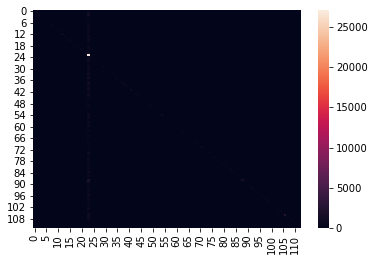

In [66]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(clf_train_labels, predm))

## Distances
How far apart are compounds, and a heatmap to try to identify any patterns in the data

### Mahalanobis distance

In [29]:
def compound_mean(compound):
    selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == compound]
    is_compound = np.isin(test_labels, selected_comps.id.values)
    comp_matrix = test_z[is_compound].numpy()
    #covar = np.cov(comp_matrix.T)
    mean = np.mean(comp_matrix, axis=0)
    mean = mean.reshape(z,1)
    return mean

def mahalanobis_dist(x, y, covar): 
    delta = x - y
    mahalanobis = delta.T @ np.linalg.inv(covar) @ delta
    mahalanobis = np.sqrt(mahalanobis)
    return np.diag(mahalanobis)[0]

In [30]:
mc_cache = {}
covar = np.cov(test_z.numpy().T)
mb_matrix = np.empty(0)
for base in comp_list:
    distances = []
    base_mean = None
    
    if base in mc_cache.keys():
        base_mean = mc_cache[base]
    else:
        base_mean = compound_mean(base)
        mc_cache[base] = base_mean
        
    for target in comp_list: 
        target_mean = None
        target_covar = None
        
        if target in mc_cache.keys():
            target_mean = mc_cache[target]
        else:
            target_mean = compound_mean(target)
            mc_cache[target] = target_mean
        
        mahalanobis = mahalanobis_dist(base_mean, target_mean, covar)
        distances.append(mahalanobis)
        
    dist_array = np.array(distances)
    
    if mb_matrix.any():
        mb_matrix = np.vstack((mb_matrix, dist_array))
    else:
        mb_matrix = dist_array
        
mb_matrix.shape

(113, 113)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


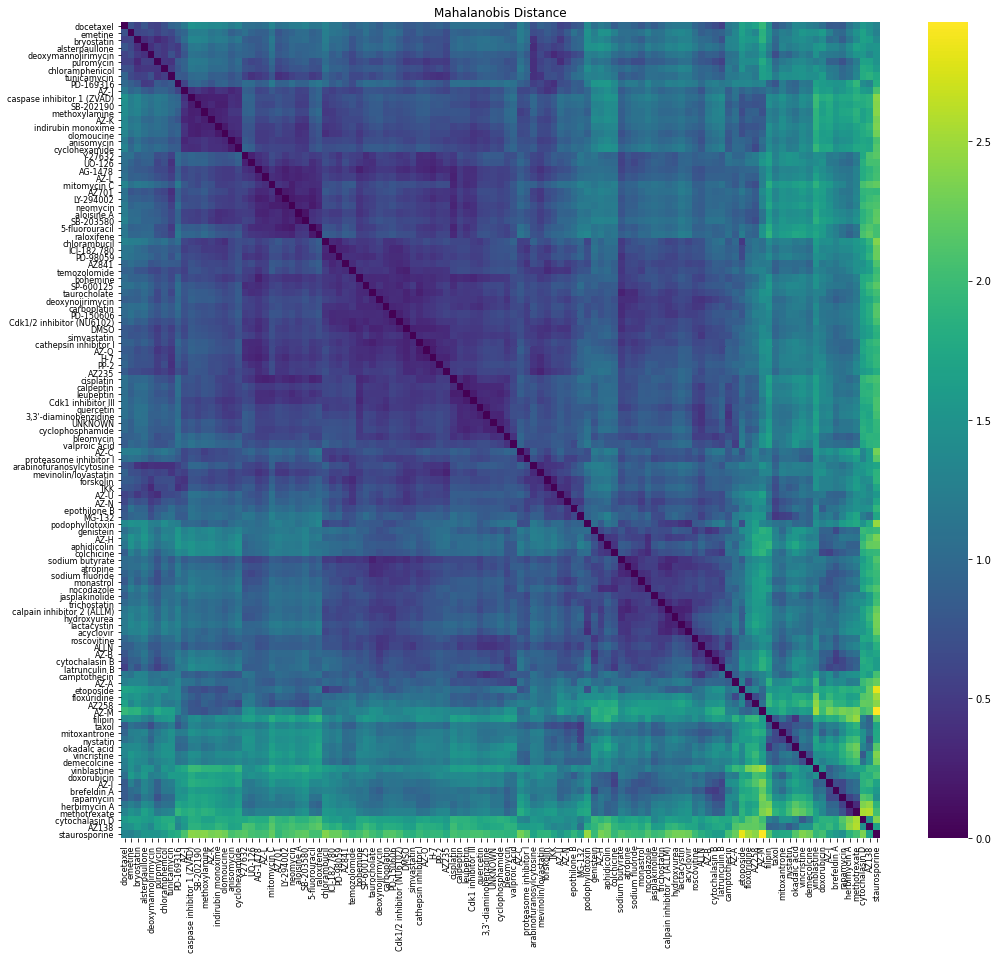

In [31]:
linkage = sch.linkage(mb_matrix, method='centroid', optimal_ordering=True)
dendro = sch.dendrogram(linkage, orientation='left', no_plot=True)

# Plot distance matrix.
labels = comp_list[dendro['leaves']]
omb = mb_matrix
index = dendro['leaves']
omb = omb[index,:]
omb = omb[:,index]
labels = comp_list[index]

plt.figure(figsize=(17,15))
fig = sns.heatmap(omb, xticklabels=labels, yticklabels=labels, cmap=plt.cm.viridis, annot=False)
plt.title('Mahalanobis Distance')
fig.set_xticklabels(labels, size=8)
fig.set_yticklabels(labels, size=8)
fig.figure.savefig(eval_dir + 'mahalanobis.png')
plt.show()

D:\Anaconda3\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\Anaconda3\lib\site-packages\seaborn\matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


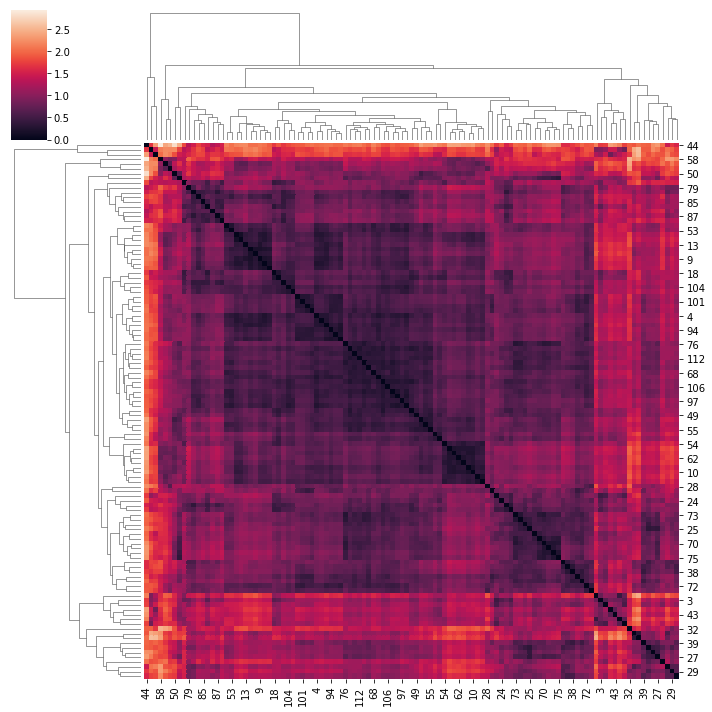

In [32]:
sns.clustermap(mb_matrix)

In [33]:
def std_matrix(x):
    sigma = np.eye(len(x[0]))
    std = np.std(x, axis=0)
    np.fill_diagonal(sigma, std)
    return sigma

def kl_distance(x, y):
    sigma_x = std_matrix(x)
    sigma_y = std_matrix(y)
    d = len(x[0])
    mu_x = np.mean(x, axis=0)
    mu_y = np.mean(y, axis=0)
    
    kl = np.trace(np.linalg.inv(sigma_y) @ sigma_x)
    kl += ((mu_y - mu_x).T @ np.linalg.inv(sigma_y) @ (mu_y - mu_x)) - d
    kl += np.log(np.linalg.det(sigma_y) / np.linalg.det(sigma_x))
    return kl

def symmetric_kl(x, y):
    kl_xy = kl_distance(x, y)
    kl_yx = kl_distance(y, x)
    
    return 0.5 * (kl_xy + kl_yx)

In [34]:
kldist_matrix = np.empty(0)
i = 0
for x in comp_list:
    distances = []
    selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == x]
    is_compound = np.isin(test_labels, selected_comps.id.values)
    comp_x = test_z[is_compound].numpy()
    for y in comp_list:
        selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == y]
        is_compound = np.isin(test_labels, selected_comps.id.values)
        comp_y = test_z[is_compound].numpy()
        distances.append(symmetric_kl(comp_x, comp_y))
        
    dist_array = np.array(distances)
    if kldist_matrix.any():
        kldist_matrix = np.vstack((kldist_matrix, dist_array))
    else:
        kldist_matrix = dist_array
kldist_matrix.shape

(113, 113)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


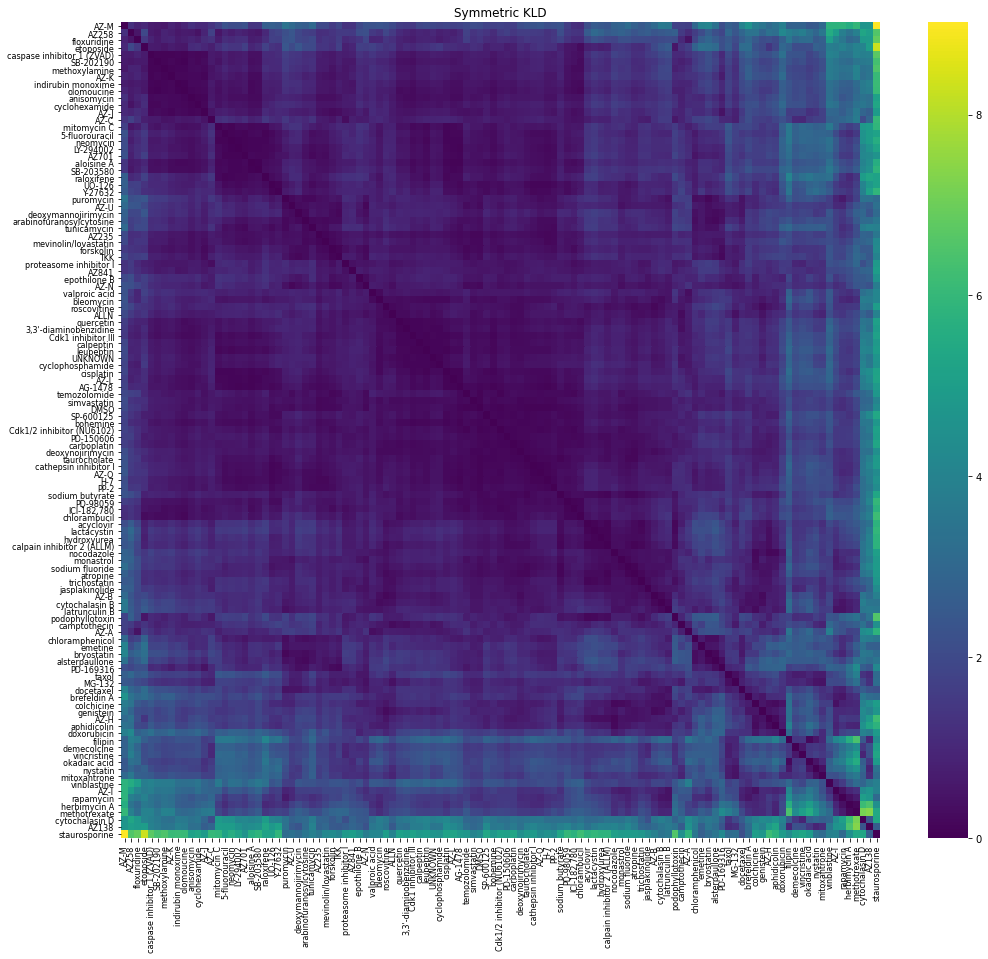

In [35]:
linkage = sch.linkage(kldist_matrix, method='centroid', optimal_ordering=True)
dendro = sch.dendrogram(linkage, orientation='left', no_plot=True)

# Plot distance matrix.
labels = comp_list[dendro['leaves']]
okl = kldist_matrix
index = dendro['leaves']
okl = okl[index,:]
okl = okl[:,index]
labels = comp_list[index]

plt.figure(figsize=(17,15))
fig = sns.heatmap(okl, xticklabels=labels, yticklabels=labels, cmap=plt.cm.viridis, annot=False)
fig.set_xticklabels(labels, size=8)
fig.set_yticklabels(labels, size=8)
fig.figure.savefig(eval_dir + 'sym_kld.png')
plt.title('Symmetric KLD')
plt.show()

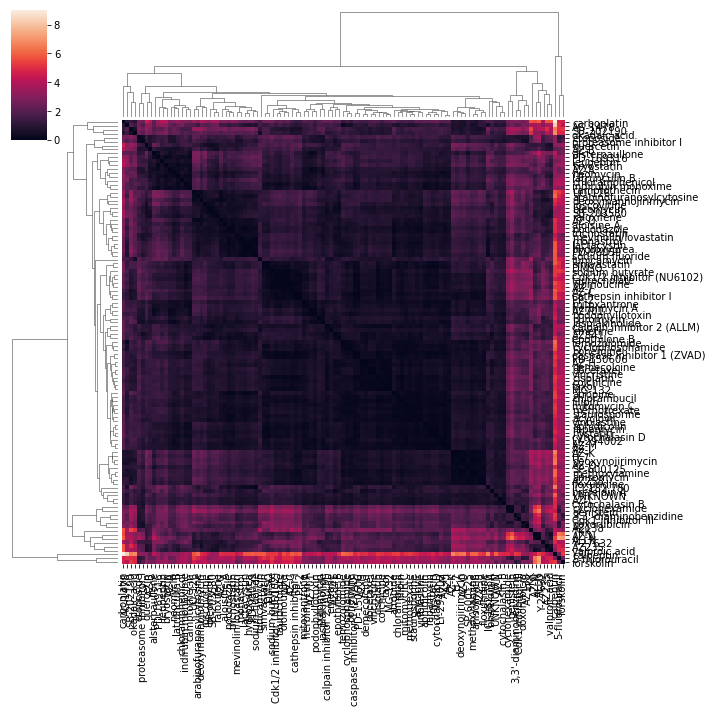

In [36]:
sns.clustermap(kldist_matrix, xticklabels=labels, yticklabels=labels)

## 2D Projection
Umap for scatter and density plots

In [37]:
leaves = dendro['leaves']
hc_comps = comp_list[leaves]
hue_df = pd.DataFrame(test_compounds, columns=['comp'])
hue_df['hue'] = -1
for idx, item in enumerate(hc_comps):
    hue_df.loc[hue_df.comp == item, 'hue'] = idx
hue_df

,comp,hue
0,monastrol,74
1,caspase inhibitor 1 (ZVAD),4
2,olomoucine,9
3,alsterpaullone,88
4,temozolomide,51
...,...,...
274729,DMSO,53
274730,AZ-I,106
274731,mitomycin C,14
274732,DMSO,53


In [38]:
reducer = umap.UMAP(random_state=22, verbose=True, low_memory=True)
z_2d = reducer.fit_transform(test_z)

UMAP(low_memory=True, random_state=22, verbose=True)
Construct fuzzy simplicial set
Thu Aug 13 17:19:51 2020 Finding Nearest Neighbors
Thu Aug 13 17:19:51 2020 Building RP forest with 31 trees
Thu Aug 13 17:20:07 2020 NN descent for 18 iterations
	 0  /  18
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	 6  /  18
	 7  /  18
	 8  /  18
	 9  /  18
	 10  /  18
	 11  /  18
	 12  /  18
	 13  /  18
	 14  /  18
	 15  /  18
	 16  /  18
	 17  /  18
Thu Aug 13 17:21:45 2020 Finished Nearest Neighbor Search
Thu Aug 13 17:21:54 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Aug 13 17:26:47 2020 Finished embedding


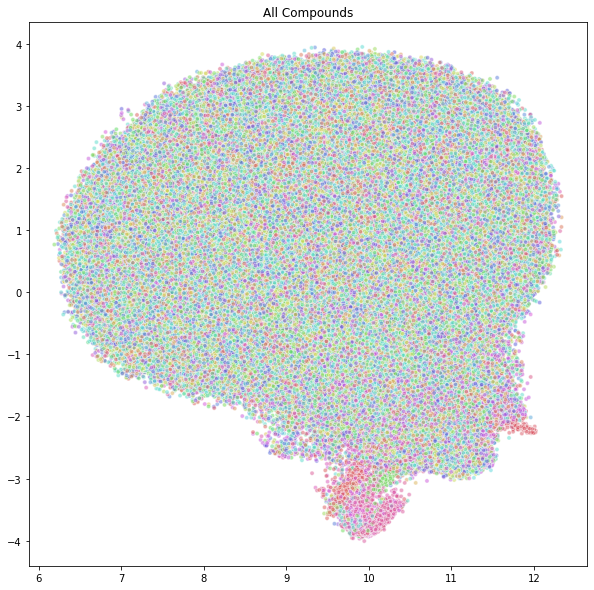

In [39]:
plt.figure(figsize=(10,10))
sns.scatterplot(z_2d[:,0], z_2d[:,1], alpha=0.5,size=1, hue=hue_df.hue, palette=sns.hls_palette(len(comp_list)),legend=False)
plt.title('All Compounds')
plt.show()

In [28]:
comp = widgets.Dropdown(
    options=['All'] + list(compound_folder['Image_Metadata_Compound'].unique()),
    value='All',
    description='Compound:',
)

def plotit(compound):
    x = z_2d[:,0]
    y = z_2d[:,1]
    title = 'All Compounds UMAP'
    if compound != 'All':
        selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == compound]
        is_compound = np.isin(test_labels, selected_comps.id.values)
        x = x[is_compound]
        y = y[is_compound]
        title = compound + ' UMAP'
    plt.figure(figsize=(10,10))
    plt.title(title)
    sns.scatterplot(x, y, alpha=0.7, size=1, palette=sns.cubehelix_palette(1))
    plt.show()
interactive(plotit, compound=comp)

interactive(children=(Dropdown(description='Compound:', options=('All', 'DMSO', 'cyclohexamide', 'anisomycin',…

In [29]:
from ipywidgets import widgets, interactive

# Make a dropdown to select the Area, or "All"
comp = widgets.Dropdown(
    options=['All'] + list(compound_folder['Image_Metadata_Compound'].unique()),
    value='All',
    description='Compound:',
)

def plotit(compound):
    x = z_2d[:,0]
    y = z_2d[:,1]
    title = 'All Compounds Density Plot'
    if compound != 'All':
        selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == compound]
        is_compound = np.isin(test_labels, selected_comps.id.values)
        x = x[is_compound]
        y = y[is_compound]
        title = compound + ' Density Plot'
    plt.figure(figsize=(10,10))
    plt.title(title)
    sns.kdeplot(x, y, legend=True, shade=True, cmap=sns.cubehelix_palette(light=1, as_cmap=True))
    plt.show()
interactive(plotit, compound=comp)

interactive(children=(Dropdown(description='Compound:', options=('All', 'DMSO', 'cyclohexamide', 'anisomycin',…

In [43]:
def get_bokeh_image(z):
    x_hat = model.decode(z.to(device)).cpu().detach()[0]
    inp = x_hat.numpy().transpose((1, 2, 0))
    mean = np.array([0.0302, 0.0660, 0.0518])
    std = np.array([0.0633, 0.0974, 0.0766])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    N = 96
    img = np.empty((N,N), dtype=np.uint32)
    view = img.view(dtype=np.uint8).reshape((N, N, 4))
    view[:,:,0] = inp[:,:,0] * 255 # copy red channel
    view[:,:,1] = inp[:,:,1] * 255 # copy blue channel
    view[:,:,2] = inp[:,:,2] * 255 # copy green channel
    view[:,:,3] = 255
    
    return [img]

output_notebook()

z = test_z[2222]
y = z.numpy()
x = np.arange(256)
img = get_bokeh_image(z)

source = ColumnDataSource(data=dict(x=x, y=y))
img_source = ColumnDataSource(data=dict(img=img))

def modify_doc(doc):
    stem = figure(title="Stem plot", y_range=[-3, 3], x_range=[-1,256], tools='hover')
    stem.segment(x0='x', x1='x', y0=0, y1='y', source=source, color='green')
    stem.circle(x='x', y='y', source=source, size=5, color='orange')
    
    cell = figure(title='Image', height=96*4, width=96*4)
    cell.image_rgba(image='img', source=img_source,x=0,y=0, dw=96, dh=96)

    def update_value(attr, old, new):
        selected_z = z_slider.value
        value = val_slider.value
        y[selected_z] = value
        source.data = dict(x=x, y=y)
        recon = get_bokeh_image(torch.tensor(y))
        img_source.data = dict(img=recon)
        
    def update_dim(attr, old, new):
        selected_z = z_slider.value
        val_slider.value = y[selected_z]
        

    z_slider = Slider(start=0, end=255, value=0, step=1, title="Z selected")
    val_slider = Slider(start=-5, end=5, value=y[0], step=0.1, title='Dimension Value')
    z_slider.on_change('value', update_dim)
    val_slider.on_change('value', update_value)

    controls = column(z_slider, val_slider)
    layout = row(stem, cell)
    layout = column(controls, layout)
    #layout = column(controls, stem)
    doc.add_root(layout)
handler = FunctionHandler(modify_doc)
app = Application(handler)
show(app)

Loading BokehJS ...

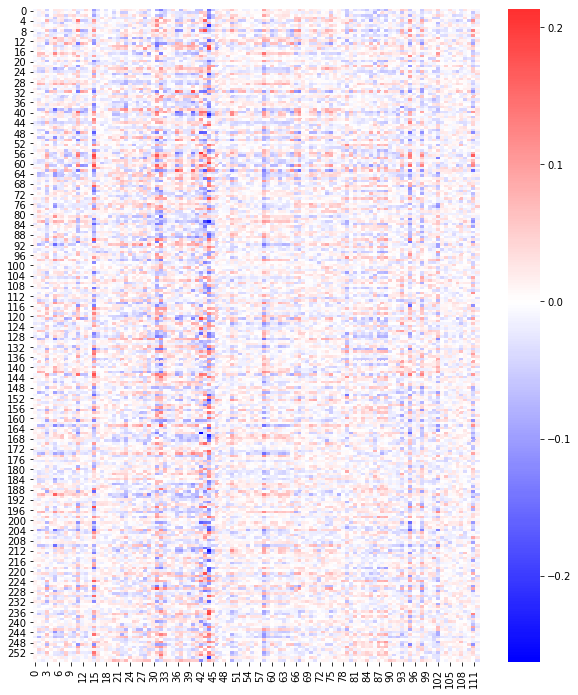

In [45]:
mean_vector = []
std_matrix = []
for compound in comp_list:
    selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == compound]
    is_compound = np.isin(test_labels, selected_comps.id.values)
    z_np = test_z[is_compound].numpy()
    mean = z_np.mean(axis=0)
    std = z_np.std(axis=0)
    mean_vector.append(mean)
    std_matrix.append(std)
mean_vector = np.asarray(mean_vector)
std_matrix = np.asarray(std_matrix)
plt.figure(figsize=(10,12))
sns.heatmap(mean_vector.T, cmap=plt.cm.bwr, center=0.0)

In [33]:
usage = np.sum(np.abs(test_z.numpy()) >= 1e-8, axis=0) / len(test_z)
mean_usage = np.mean(usage)
std_usage = np.std(usage)
print('Mean of Z features used: ', mean_usage)
print('STD of Z features used: ', std_usage)

Mean of Z features used:  0.34366372336514595
STD of Z features used:  0.0030680591823978184


In [62]:
z_used = np.count_nonzero(test_z, axis=1)
mean_z_used = np.mean(z_used)
std_z_used = np.std(z_used)
print('Mean of Z features used: ', mean_z_used)
print('STD of Z features used: ', std_z_used)

Mean of Z features used:  132.16476664701128
STD of Z features used:  8.055801032489885


In [29]:
z_used = np.sum(np.abs(test_z.numpy()) >= 1e-8, axis=1)
mean_z_used = np.mean(z_used)
std_z_used = np.std(z_used)
print('Mean of Z features used: ', mean_z_used)
print('STD of Z features used: ', std_z_used)

Mean of Z features used:  87.97791318147736
STD of Z features used:  7.654296108341291


In [35]:
min(np.sum(np.abs(test_z.numpy()) >= 1e-8, axis=0) / len(test_z))

0.33433066165818576

In [5]:
image_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))

label_mapping = image_dataset.class_to_idx

metadata = pd.read_csv(metadata_dir + 'compound_to_cell.csv')
metadata['Image_FileName_DAPI'] = metadata['Image_FileName_DAPI'].apply(lambda x: x.split('.tif')[0])
compound_folder = metadata[['Image_FileName_DAPI', 'Image_Metadata_Compound']].sort_values('Image_FileName_DAPI')
cf_id = compound_folder['Image_FileName_DAPI'].apply(lambda x: int(label_mapping.get(x, -1)))
compound_folder['id'] = cf_id
compound_folder = compound_folder[compound_folder.id != -1]
comp_list = compound_folder['Image_Metadata_Compound'].unique()
comp_count = {}
for comp_name in comp_list:
    comp_count[comp_name] = 0


loader = data.DataLoader(
    image_dataset,
    batch_size=128,
    num_workers=6,
    pin_memory=True,
    shuffle=False
)

mean = 0.
std = 0.
nb_samples = 0.
total_batches = len(loader)
for idx, (dat, labels) in enumerate(loader):
    if idx % (total_batches // 100) == 0:
        print("Batch ", idx, "/", total_batches)
    batch_samples = dat.size(0)
    dat = dat.view(batch_samples, dat.size(1), -1)
    mean += dat.mean(2).sum(0)
    std += dat.std(2).sum(0)
    nb_samples += batch_samples
    
    for label in labels:
        compound = compound_folder[compound_folder.id == label.item()]['Image_Metadata_Compound'].values[0]
        comp_count[compound] = comp_count[compound] + 1

mean /= nb_samples
std /= nb_samples
print("mean: ", mean)
print("std: ", std)
comp_count

Batch  0 / 10732
Batch  107 / 10732
Batch  214 / 10732
Batch  321 / 10732
Batch  428 / 10732
Batch  535 / 10732
Batch  642 / 10732
Batch  749 / 10732
Batch  856 / 10732
Batch  963 / 10732
Batch  1070 / 10732
Batch  1177 / 10732
Batch  1284 / 10732
Batch  1391 / 10732
Batch  1498 / 10732
Batch  1605 / 10732
Batch  1712 / 10732
Batch  1819 / 10732
Batch  1926 / 10732
Batch  2033 / 10732
Batch  2140 / 10732
Batch  2247 / 10732
Batch  2354 / 10732
Batch  2461 / 10732
Batch  2568 / 10732
Batch  2675 / 10732
Batch  2782 / 10732
Batch  2889 / 10732
Batch  2996 / 10732
Batch  3103 / 10732
Batch  3210 / 10732
Batch  3317 / 10732
Batch  3424 / 10732
Batch  3531 / 10732
Batch  3638 / 10732
Batch  3745 / 10732
Batch  3852 / 10732
Batch  3959 / 10732
Batch  4066 / 10732
Batch  4173 / 10732
Batch  4280 / 10732
Batch  4387 / 10732
Batch  4494 / 10732
Batch  4601 / 10732
Batch  4708 / 10732
Batch  4815 / 10732
Batch  4922 / 10732
Batch  5029 / 10732
Batch  5136 / 10732
Batch  5243 / 10732
Batch  5350 

{'DMSO': 210508,
 'cyclohexamide': 11143,
 'anisomycin': 7231,
 'taxol': 29787,
 'AG-1478': 23830,
 'AZ258': 8212,
 'olomoucine': 14407,
 'caspase inhibitor 1 (ZVAD)': 17927,
 'tunicamycin': 11943,
 'neomycin': 18408,
 'indirubin monoxime': 12937,
 'okadaic acid': 13751,
 '5-fluorouracil': 15435,
 'mitomycin C': 12574,
 'Cdk1/2 inhibitor (NU6102)': 15324,
 'AZ138': 2899,
 'AZ-U': 17053,
 'temozolomide': 17944,
 'TKK': 20075,
 'monastrol': 32543,
 'cytochalasin B': 8705,
 'latrunculin B': 10176,
 'aphidicolin': 10631,
 'doxorubicin': 11154,
 'epothilone B': 5224,
 'nocodazole': 4602,
 'colchicine': 9490,
 'AZ-H': 11160,
 'AZ-A': 5086,
 'AZ-I': 13255,
 'jasplakinolide': 7530,
 'cytochalasin D': 6640,
 'vinblastine': 1844,
 'MG-132': 4428,
 'ALLN': 6672,
 'roscovitine': 9278,
 'herbimycin A': 8806,
 'rapamycin': 8918,
 'AZ-B': 8873,
 'genistein': 7555,
 'methotrexate': 8205,
 'brefeldin A': 5391,
 'vincristine': 1060,
 'demecolcine': 524,
 'staurosporine': 4692,
 'emetine': 4977,
 'AZ-C':

In [19]:
compound_count = pd.DataFrame.from_dict(comp_count, orient='index', columns=['count']).sort_values(by='count', ascending=False)
print(compound_count.to_string())

                             count
DMSO                        210508
monastrol                    32543
taxol                        29787
AG-1478                      23830
TKK                          20075
alsterpaullone               19815
Y-27632                      19704
neomycin                     18408
temozolomide                 17944
caspase inhibitor 1 (ZVAD)   17927
SB-203580                    17184
AZ-U                         17053
arabinofuranosylcytosine     17003
ICI-182,780                  16690
UO-126                       16279
LY-294002                    16129
methoxylamine                16016
puromycin                    15634
5-fluorouracil               15435
Cdk1/2 inhibitor (NU6102)    15324
forskolin                    15271
PD-169316                    15248
AZ-K                         15217
cisplatin                    15154
chlorambucil                 15125
PD-98059                     14669
olomoucine                   14407
bryostatin          

In [27]:
compound_count['count'].count()

113

In [24]:
compound_count['proportion'] = compound_count['count'] / compound_count['count'].sum()

In [25]:
print(compound_count.to_string())

                             count  proportion
DMSO                        210508    0.153245
monastrol                    32543    0.023691
taxol                        29787    0.021684
AG-1478                      23830    0.017348
TKK                          20075    0.014614
alsterpaullone               19815    0.014425
Y-27632                      19704    0.014344
neomycin                     18408    0.013401
temozolomide                 17944    0.013063
caspase inhibitor 1 (ZVAD)   17927    0.013050
SB-203580                    17184    0.012510
AZ-U                         17053    0.012414
arabinofuranosylcytosine     17003    0.012378
ICI-182,780                  16690    0.012150
UO-126                       16279    0.011851
LY-294002                    16129    0.011742
methoxylamine                16016    0.011659
puromycin                    15634    0.011381
5-fluorouracil               15435    0.011236
Cdk1/2 inhibitor (NU6102)    15324    0.011156
forskolin    

In [15]:
mean

tensor([0.0335, 0.0568, 0.0550])

In [16]:
std

tensor([0.0669, 0.0882, 0.0839])